In [76]:
# %%
# === IMPORTS ===
import pandas as pd
import numpy as np
import joblib
import os
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import (
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    precision_score,
    recall_score,
)
import matplotlib.pyplot as plt
import seaborn as sns

print("✅ Imports OK")

✅ Imports OK


In [77]:
# %%
# === CHARGEMENT DES DONNÉES TRAIN/VAL ===
print("=" * 60)
print("CHARGEMENT DES DONNÉES TRAIN/VAL")
print("=" * 60)

# Charger le pickle train/val
catboost_data = joblib.load("../data/processed/catboost_ready.pkl")

X_train = catboost_data["X_train"]
y_train = catboost_data["y_train"]
X_val = catboost_data["X_val"]
y_val = catboost_data["y_val"]
cat_indices = catboost_data["cat_indices"]
cat_features_names = catboost_data.get("cat_features_names", [])

print(f"✅ Données train/val chargées:")
print(f"   Train: {X_train.shape}")
print(f"   Val: {X_val.shape}")
print(f"   Categorical indices: {cat_indices}")
print(f"   Categorical features: {cat_features_names}")
print(f"\n   Target balance (train):")
print(pd.Series(y_train).value_counts(normalize=True))

CHARGEMENT DES DONNÉES TRAIN/VAL
✅ Données train/val chargées:
   Train: (11521, 64)
   Val: (1934, 64)
   Categorical indices: [9, 7, 10, 11, 5]
   Categorical features: ['Category', 'Time_of_Day', 'Device_Type', 'Payment_Method', 'Referral_Source']

   Target balance (train):
Purchase
0    0.626335
1    0.373665
Name: proportion, dtype: float64


In [78]:
# %%
# === CHARGEMENT DU TEST SET PREPROCESSED ===
print("\n" + "=" * 60)
print("CHARGEMENT DU TEST SET")
print("=" * 60)

# Charger le test preprocessed
test_data = joblib.load("../data/processed/catboost_ready_test.pkl")
X_test = test_data["X_test"]
test_ids = test_data["test_ids"]

print(f"✅ Test chargé:")
print(f"   X_test: {X_test.shape}")
print(f"   Test IDs: {len(test_ids)}")

# Vérifier que train et test ont les mêmes colonnes
missing_in_test = set(X_train.columns) - set(X_test.columns)
extra_in_test = set(X_test.columns) - set(X_train.columns)

if missing_in_test:
    print(f"\n⚠️ Colonnes manquantes dans test: {missing_in_test}")
    # Ajouter les colonnes manquantes avec 0
    for col in missing_in_test:
        X_test[col] = 0

if extra_in_test:
    print(f"\n⚠️ Colonnes en trop dans test: {extra_in_test}")
    # Supprimer les colonnes en trop
    X_test = X_test.drop(columns=list(extra_in_test))

# Réordonner les colonnes du test comme train
X_test = X_test[X_train.columns]
print(f"\n✅ Test aligné avec train: {X_test.shape}")


CHARGEMENT DU TEST SET
✅ Test chargé:
   X_test: (6145, 65)
   Test IDs: 6145

⚠️ Colonnes en trop dans test: {'Day'}

✅ Test aligné avec train: (6145, 64)


In [79]:
# %%
# === CRÉATION DES POOLS CATBOOST ===
print("\n" + "=" * 60)
print("CRÉATION DES POOLS CATBOOST")
print("=" * 60)

train_pool = Pool(data=X_train, label=y_train, cat_features=cat_indices)
val_pool = Pool(data=X_val, label=y_val, cat_features=cat_indices)
test_pool = Pool(data=X_test, cat_features=cat_indices)

print("✅ Pools créés (train, val, test)")


CRÉATION DES POOLS CATBOOST
✅ Pools créés (train, val, test)


In [80]:
# %%
# === ENTRAÎNEMENT CATBOOST ===
print("\n" + "=" * 60)
print("ENTRAÎNEMENT DU MODÈLE CATBOOST")
print("=" * 60)

model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    l2_leaf_reg=3,
    loss_function="Logloss",
    eval_metric="F1",
    random_seed=42,
    verbose=100,
    early_stopping_rounds=100,
    task_type="CPU",  # Mets 'GPU' si disponible
    auto_class_weights="Balanced",  # Gérer le déséquilibre
)

model.fit(train_pool, eval_set=val_pool, use_best_model=True, plot=False)

print("\n✅ Entraînement terminé")
print(f"   Best iteration: {model.best_iteration_}")
print(f"   Best F1 score: {model.best_score_['validation']['F1']:.4f}")


ENTRAÎNEMENT DU MODÈLE CATBOOST
0:	learn: 0.8112887	test: 0.7760905	best: 0.7760905 (0)	total: 6.22ms	remaining: 6.21s
100:	learn: 0.8702775	test: 0.8312166	best: 0.8324628 (92)	total: 571ms	remaining: 5.08s
200:	learn: 0.8829766	test: 0.8406052	best: 0.8424737 (185)	total: 1.12s	remaining: 4.46s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8424736865
bestIteration = 185

Shrink model to first 186 iterations.

✅ Entraînement terminé
   Best iteration: 185
   Best F1 score: 0.8425


In [81]:
# %%
# === PRÉDICTIONS SUR VALIDATION ===
print("\n" + "=" * 60)
print("ÉVALUATION SUR VALIDATION")
print("=" * 60)

y_val_pred_proba = model.predict_proba(val_pool)[:, 1]
y_val_pred = model.predict(val_pool).astype(int)

# Métriques détaillées
f1_val = f1_score(y_val, y_val_pred)
precision_val = precision_score(y_val, y_val_pred)
recall_val = recall_score(y_val, y_val_pred)
roc_auc_val = roc_auc_score(y_val, y_val_pred_proba)

print(f"\n📊 RÉSULTATS SUR VALIDATION:")
print(f"   F1-Score:    {f1_val:.4f}")
print(f"   Precision:   {precision_val:.4f}")
print(f"   Recall:      {recall_val:.4f}")
print(f"   ROC-AUC:     {roc_auc_val:.4f}")

print("\n📋 Classification Report:")
print(
    classification_report(y_val, y_val_pred, target_names=["No Purchase", "Purchase"])
)


ÉVALUATION SUR VALIDATION

📊 RÉSULTATS SUR VALIDATION:
   F1-Score:    0.7909
   Precision:   0.7228
   Recall:      0.8732
   ROC-AUC:     0.9301

📋 Classification Report:
              precision    recall  f1-score   support

 No Purchase       0.93      0.83      0.88      1295
    Purchase       0.72      0.87      0.79       639

    accuracy                           0.85      1934
   macro avg       0.83      0.85      0.84      1934
weighted avg       0.86      0.85      0.85      1934




CONFUSION MATRIX - VALIDATION


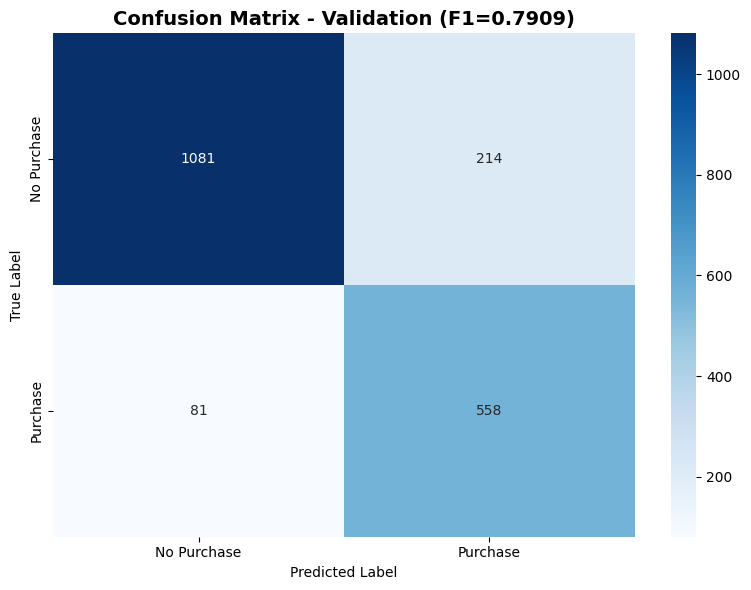


Détails de la confusion matrix:
   True Negatives:  1081
   False Positives: 214
   False Negatives: 81
   True Positives:  558


In [82]:
# %%
# === CONFUSION MATRIX ===
print("\n" + "=" * 60)
print("CONFUSION MATRIX - VALIDATION")
print("=" * 60)

cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["No Purchase", "Purchase"],
    yticklabels=["No Purchase", "Purchase"],
)
plt.title(
    f"Confusion Matrix - Validation (F1={f1_val:.4f})", fontsize=14, fontweight="bold"
)
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()

# Afficher les métriques de la matrice
tn, fp, fn, tp = cm.ravel()
print(f"\nDétails de la confusion matrix:")
print(f"   True Negatives:  {tn}")
print(f"   False Positives: {fp}")
print(f"   False Negatives: {fn}")
print(f"   True Positives:  {tp}")


FEATURE IMPORTANCES (TOP 20)
                   feature  importance
             Items_In_Cart   27.129115
           Cart_Efficiency   15.438022
        Email_x_Engagement    9.002530
     Engagement_x_Campaign    6.248570
               Device_Type    4.805249
         Cart_x_Engagement    4.156836
                 Net_Price    4.100641
                     Price    3.981953
        HighValue_Category    3.342097
              Price_Bucket    3.076941
          Engagement_Score    2.971559
      Engagement_per_Price    1.880552
                  Category    1.869986
              Reviews_Read    1.477359
                Price_Sine    1.346219
         Email_Interaction    0.930685
           Day_to_Campaign    0.884749
Socioeconomic_Status_Score    0.804879
      Net_Price_x_Campaign    0.726126
              Email_Impact    0.715825


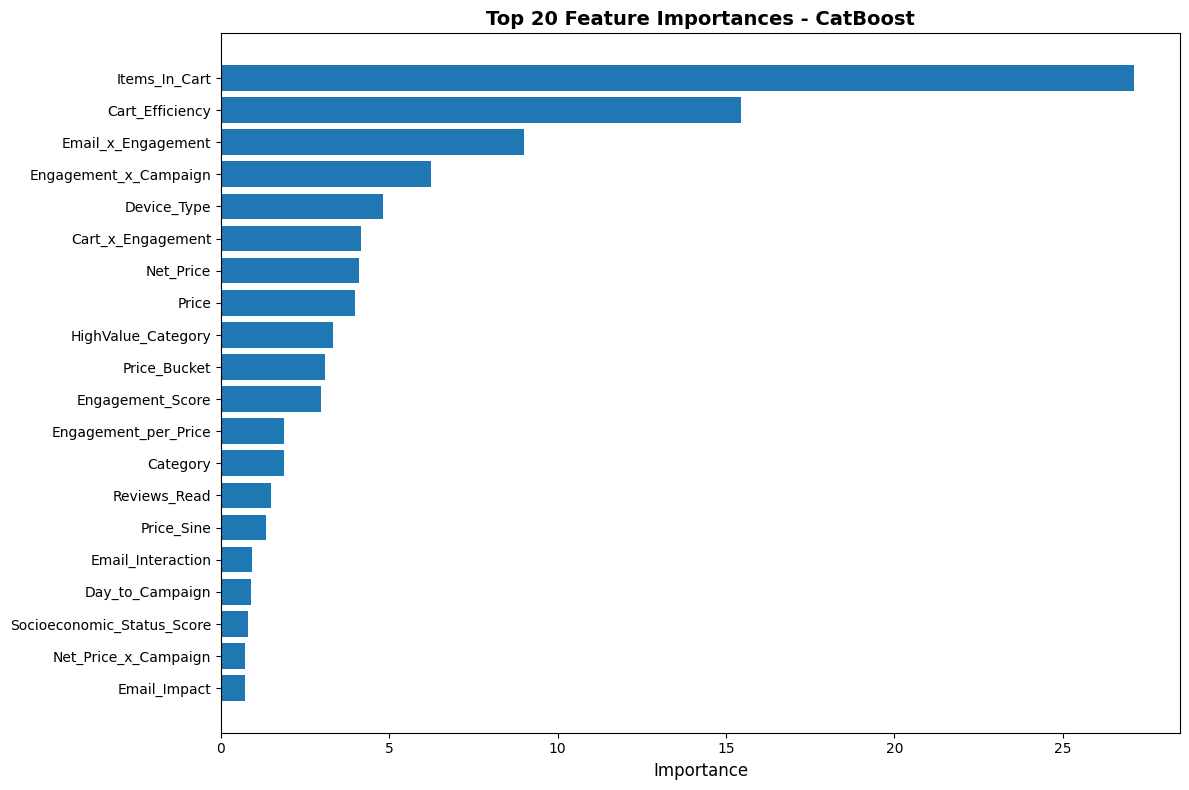

In [83]:
# %%
# === FEATURE IMPORTANCES ===
print("\n" + "=" * 60)
print("FEATURE IMPORTANCES (TOP 20)")
print("=" * 60)

feature_importance = model.get_feature_importance(train_pool)
feature_names = X_train.columns

importance_df = pd.DataFrame(
    {"feature": feature_names, "importance": feature_importance}
).sort_values("importance", ascending=False)

print(importance_df.head(20).to_string(index=False))

# Plot
plt.figure(figsize=(12, 8))
top_20 = importance_df.head(20)
plt.barh(range(len(top_20)), top_20["importance"])
plt.yticks(range(len(top_20)), top_20["feature"])
plt.xlabel("Importance", fontsize=12)
plt.title("Top 20 Feature Importances - CatBoost", fontsize=14, fontweight="bold")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [84]:
# %%
# === PRÉDICTIONS SUR TEST ===
print("\n" + "=" * 60)
print("PRÉDICTIONS SUR TEST SET")
print("=" * 60)

y_test_pred_proba = model.predict_proba(test_pool)[:, 1]
y_test_pred = model.predict(test_pool).astype(int)

print(f"✅ Prédictions générées:")
print(f"   Nombre de prédictions: {len(y_test_pred)}")
print(f"   Taux de prédiction positive: {y_test_pred.mean():.2%}")
print(f"\n   Distribution des prédictions:")
print(pd.Series(y_test_pred).value_counts())


PRÉDICTIONS SUR TEST SET
✅ Prédictions générées:
   Nombre de prédictions: 6145
   Taux de prédiction positive: 45.39%

   Distribution des prédictions:
0    3356
1    2789
Name: count, dtype: int64


In [85]:
# %%
# === CRÉATION DU FICHIER DE SOUMISSION ===
print("\n" + "=" * 60)
print("CRÉATION DU FICHIER DE SOUMISSION")
print("=" * 60)

# Créer la soumission
submission = pd.DataFrame({"id": test_ids, "Purchase": y_test_pred})

# Créer le dossier submissions si nécessaire
os.makedirs("../data/submissions", exist_ok=True)

# Sauvegarder
submission_path = "../data/submissions/catboost_submission.csv"
submission.to_csv(submission_path, index=False)

print(f"✅ Soumission sauvegardée: {submission_path}")
print(f"   Shape: {submission.shape}")
print(f"   Colonnes: {submission.columns.tolist()}")
print("\n   Aperçu de la soumission:")
print(submission.head(10))
print("\n   Statistiques:")
print(submission["Purchase"].value_counts())


CRÉATION DU FICHIER DE SOUMISSION
✅ Soumission sauvegardée: ../data/submissions/catboost_submission.csv
   Shape: (6145, 2)
   Colonnes: ['id', 'Purchase']

   Aperçu de la soumission:
   id  Purchase
0   1         0
1   2         1
2   3         0
3   4         1
4   5         1
5   6         1
6   7         1
7   8         1
8   9         1
9  10         1

   Statistiques:
Purchase
0    3356
1    2789
Name: count, dtype: int64



ANALYSE DES PROBABILITÉS DE PRÉDICTION


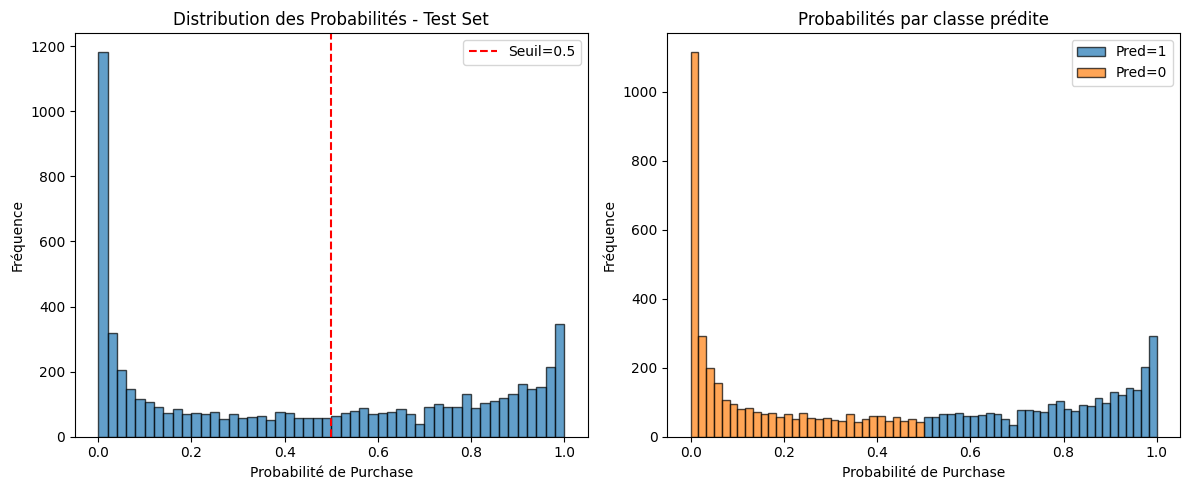

Statistiques des probabilités:
   Min:  0.0001
   Max:  0.9997
   Mean: 0.4382
   Std:  0.3684


In [86]:
# %%
# === ANALYSE DES PROBABILITÉS ===
print("\n" + "=" * 60)
print("ANALYSE DES PROBABILITÉS DE PRÉDICTION")
print("=" * 60)

# Distribution des probabilités
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(y_test_pred_proba, bins=50, edgecolor="black", alpha=0.7)
plt.xlabel("Probabilité de Purchase")
plt.ylabel("Fréquence")
plt.title("Distribution des Probabilités - Test Set")
plt.axvline(0.5, color="red", linestyle="--", label="Seuil=0.5")
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(
    y_test_pred_proba[y_test_pred == 1],
    bins=30,
    alpha=0.7,
    label="Pred=1",
    edgecolor="black",
)
plt.hist(
    y_test_pred_proba[y_test_pred == 0],
    bins=30,
    alpha=0.7,
    label="Pred=0",
    edgecolor="black",
)
plt.xlabel("Probabilité de Purchase")
plt.ylabel("Fréquence")
plt.title("Probabilités par classe prédite")
plt.legend()

plt.tight_layout()
plt.show()

print(f"Statistiques des probabilités:")
print(f"   Min:  {y_test_pred_proba.min():.4f}")
print(f"   Max:  {y_test_pred_proba.max():.4f}")
print(f"   Mean: {y_test_pred_proba.mean():.4f}")
print(f"   Std:  {y_test_pred_proba.std():.4f}")

In [87]:
# %%
# === SAUVEGARDE DU MODÈLE ===
print("\n" + "=" * 60)
print("SAUVEGARDE DU MODÈLE")
print("=" * 60)

os.makedirs("../models", exist_ok=True)
model_path = "../models/catboost_model.cbm"
model.save_model(model_path)

print(f"✅ Modèle sauvegardé: {model_path}")

# Sauvegarder aussi les métadonnées
metadata = {
    "f1_score": f1_val,
    "precision": precision_val,
    "recall": recall_val,
    "roc_auc": roc_auc_val,
    "best_iteration": model.best_iteration_,
    "n_features": X_train.shape[1],
    "cat_features": cat_features_names,
}

metadata_path = "../models/catboost_metadata.pkl"
joblib.dump(metadata, metadata_path)
print(f"✅ Métadonnées sauvegardées: {metadata_path}")


SAUVEGARDE DU MODÈLE
✅ Modèle sauvegardé: ../models/catboost_model.cbm
✅ Métadonnées sauvegardées: ../models/catboost_metadata.pkl


In [88]:
# %%
# === RÉSUMÉ FINAL ===
print("\n" + "=" * 60)
print("🎉 PIPELINE CATBOOST TERMINÉ !")
print("=" * 60)

print(f"\n📊 MÉTRIQUES FINALES (VALIDATION):")
print(f"   F1-Score:    {f1_val:.4f}")
print(f"   Precision:   {precision_val:.4f}")
print(f"   Recall:      {recall_val:.4f}")
print(f"   ROC-AUC:     {roc_auc_val:.4f}")

print(f"\n📁 FICHIERS GÉNÉRÉS:")
print(f"   Soumission: {submission_path}")
print(f"   Modèle:     {model_path}")
print(f"   Métadonnées: {metadata_path}")

print(f"\n🎯 PROCHAINES ÉTAPES:")
print(f"   1. Vérifier le fichier de soumission")
print(f"   2. Soumettre sur la plateforme de compétition")
print(f"   3. Analyser les erreurs si besoin")
print(f"   4. Tester d'autres modèles ou hyperparamètres")

print("\n" + "=" * 60)


🎉 PIPELINE CATBOOST TERMINÉ !

📊 MÉTRIQUES FINALES (VALIDATION):
   F1-Score:    0.7909
   Precision:   0.7228
   Recall:      0.8732
   ROC-AUC:     0.9301

📁 FICHIERS GÉNÉRÉS:
   Soumission: ../data/submissions/catboost_submission.csv
   Modèle:     ../models/catboost_model.cbm
   Métadonnées: ../models/catboost_metadata.pkl

🎯 PROCHAINES ÉTAPES:
   1. Vérifier le fichier de soumission
   2. Soumettre sur la plateforme de compétition
   3. Analyser les erreurs si besoin
   4. Tester d'autres modèles ou hyperparamètres



✅ Imports OK
CHARGEMENT DES DONNÉES TRAIN/VAL
✅ Données train/val chargées:
   Train: (11521, 64)
   Val: (1934, 64)
   Target balance: {0: 0.6263345195729537, 1: 0.3736654804270463}

CHARGEMENT DU TEST SET
⚠️ Colonnes en trop dans test: {'Day'}
✅ Test aligné: (6145, 64)

CRÉATION DES POOLS CATBOOST
✅ Pools créés

TEST DE 3 CONFIGURATIONS

--- Baseline ---
F1: 0.7909 | Precision: 0.7228 | Recall: 0.8732

--- Plus Profond ---
F1: 0.7825 | Precision: 0.7130 | Recall: 0.8670

--- Très Profond ---
F1: 0.7783 | Precision: 0.7072 | Recall: 0.8654

COMPARAISON DES CONFIGURATIONS
      Config       F1  Precision   Recall  ROC-AUC  Best Iter
    Baseline 0.790928   0.722798 0.873239 0.930125        185
Plus Profond 0.782486   0.712999 0.866980 0.927215        193
Très Profond 0.778325   0.707161 0.865415 0.924753        125

🏆 MEILLEUR MODÈLE: Baseline
   F1-Score: 0.7909

OPTIMISATION DU SEUIL DE DÉCISION
 Threshold       F1  Precision   Recall
      0.40 0.761341   0.656463 0.906103
      0.4

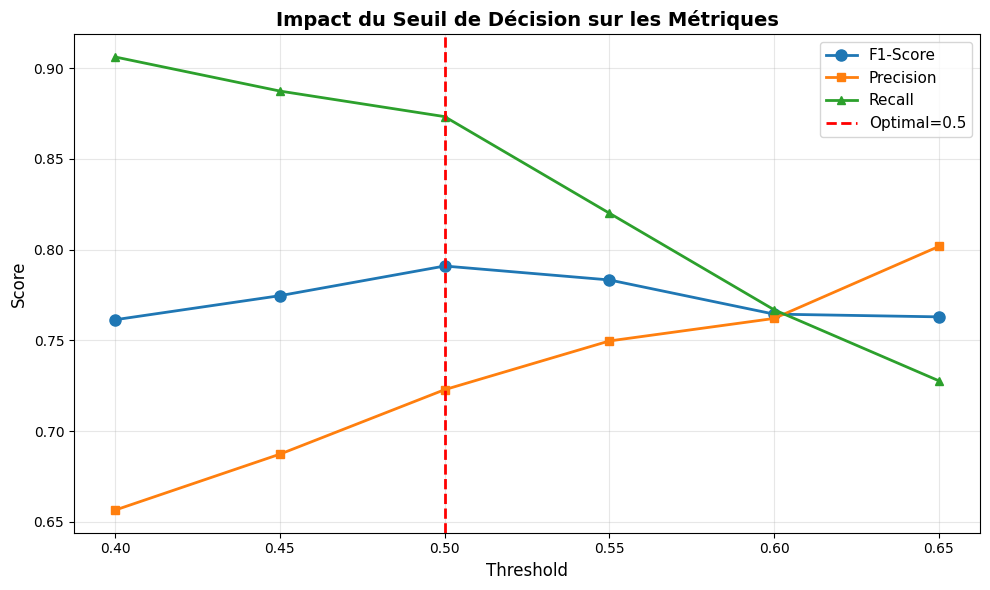


ÉVALUATION FINALE SUR VALIDATION

📊 RÉSULTATS FINAUX:
   Modèle:      Baseline
   Seuil:       0.5
   F1-Score:    0.7909
   Precision:   0.7228
   Recall:      0.8732
   ROC-AUC:     0.9301

📋 Classification Report:
              precision    recall  f1-score   support

 No Purchase       0.93      0.83      0.88      1295
    Purchase       0.72      0.87      0.79       639

    accuracy                           0.85      1934
   macro avg       0.83      0.85      0.84      1934
weighted avg       0.86      0.85      0.85      1934



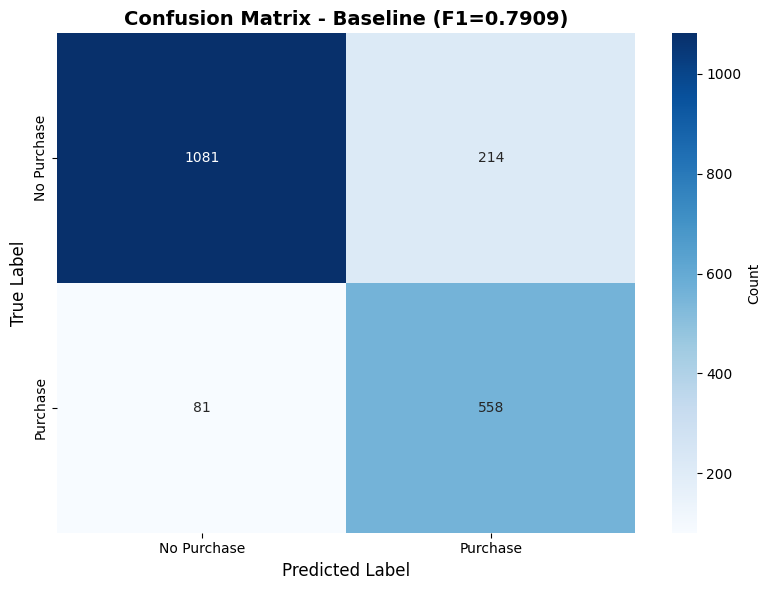


Détails:
   True Negatives:  1081 (bien prédit non-achat)
   False Positives: 214 (faux achat prédit)
   False Negatives: 81 (achat raté)
   True Positives:  558 (bien prédit achat)

FEATURE IMPORTANCES (TOP 20)
                   feature  importance
             Items_In_Cart   27.129115
           Cart_Efficiency   15.438022
        Email_x_Engagement    9.002530
     Engagement_x_Campaign    6.248570
               Device_Type    4.805249
         Cart_x_Engagement    4.156836
                 Net_Price    4.100641
                     Price    3.981953
        HighValue_Category    3.342097
              Price_Bucket    3.076941
          Engagement_Score    2.971559
      Engagement_per_Price    1.880552
                  Category    1.869986
              Reviews_Read    1.477359
                Price_Sine    1.346219
         Email_Interaction    0.930685
           Day_to_Campaign    0.884749
Socioeconomic_Status_Score    0.804879
      Net_Price_x_Campaign    0.726126
       

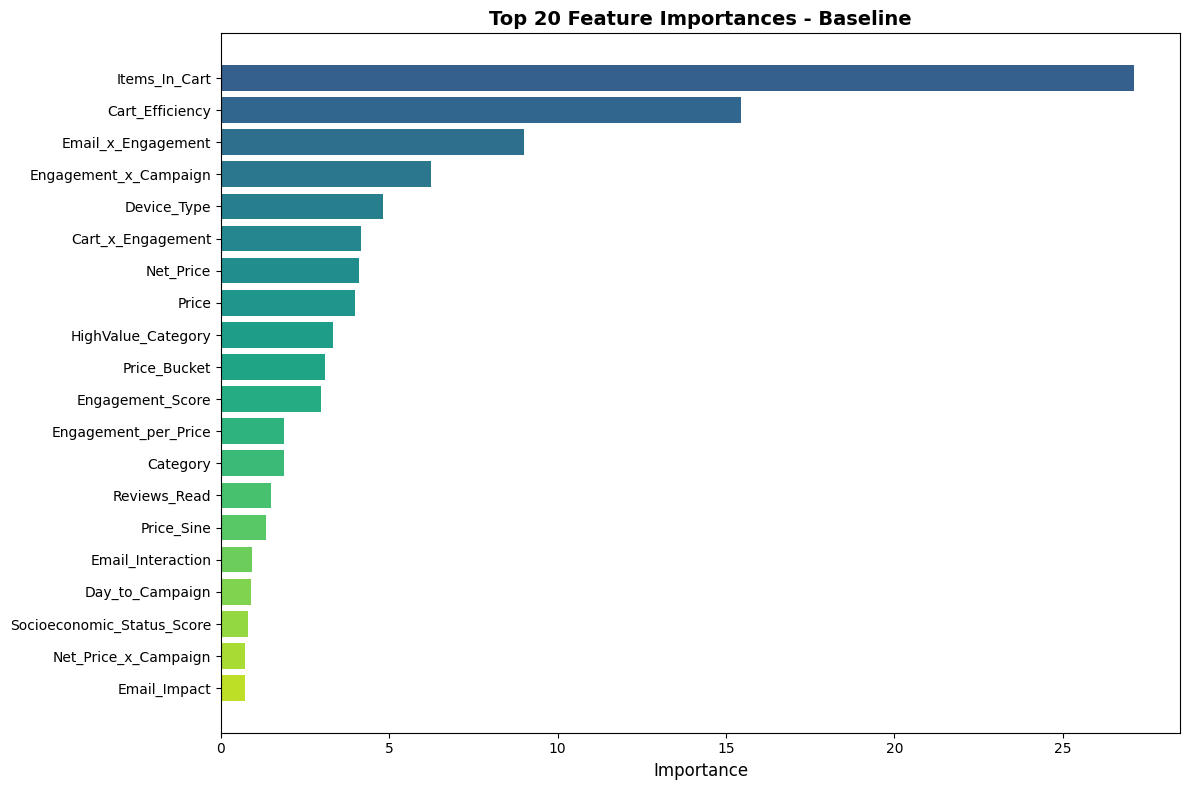


PRÉDICTIONS SUR TEST SET
✅ Prédictions générées:
   Modèle:  Baseline
   Seuil:   0.5
   Nombre:  6145
   Taux positif: 45.39%

   Distribution:
          count
Purchase       
0          3356
1          2789

ANALYSE DES PROBABILITÉS


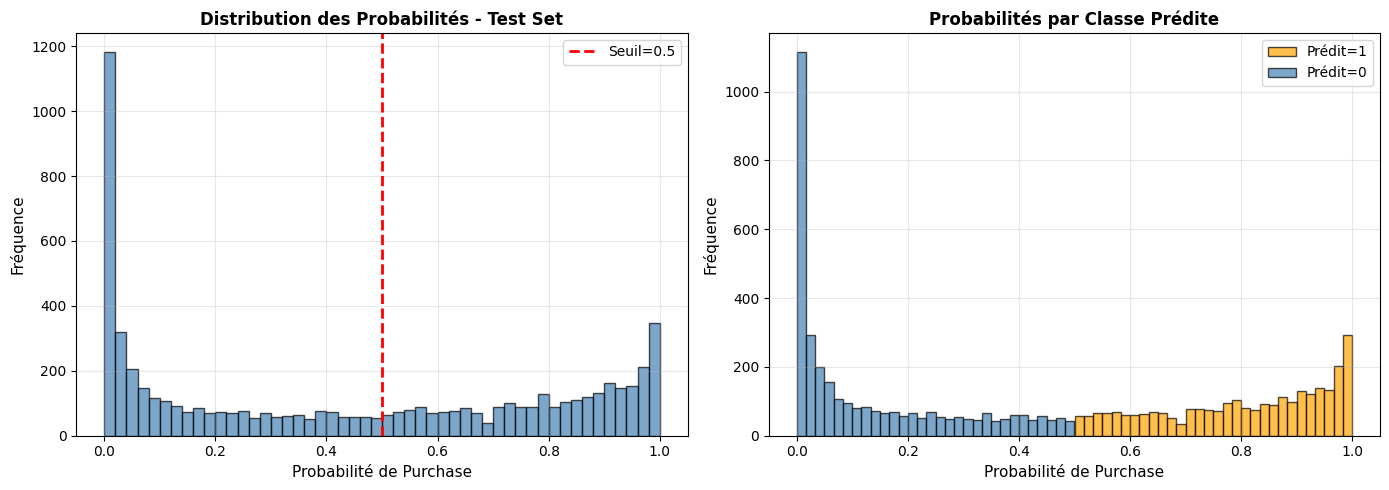


📊 Statistiques des probabilités:
   Min:    0.0001
   25%:    0.0435
   Médiane: 0.4059
   75%:    0.8053
   Max:    0.9997
   Mean:   0.4382
   Std:    0.3684

CRÉATION DU FICHIER DE SOUMISSION
✅ Soumission sauvegardée: ../data/submissions/catboost_BEST_submission.csv

📊 Résumé de la soumission:
   Lignes: 6145
   Prédictions positives: 2789 (45.39%)
   Prédictions négatives: 3356 (54.61%)

   Aperçu:
   id  Purchase
0   1         0
1   2         1
2   3         0
3   4         1
4   5         1
5   6         1
6   7         1
7   8         1
8   9         1
9  10         1

SAUVEGARDE DU MODÈLE
✅ Modèle sauvegardé: ../models/catboost_BEST_model.cbm
✅ Métadonnées sauvegardées: ../models/catboost_BEST_metadata.pkl

🎉 PIPELINE COMPLET TERMINÉ !

🏆 MEILLEUR MODÈLE SÉLECTIONNÉ:
   Configuration: Baseline
   Seuil optimal: 0.5

📊 PERFORMANCE (VALIDATION):
   F1-Score:    0.7909
   Precision:   0.7228
   Recall:      0.8732
   ROC-AUC:     0.9301

📁 FICHIERS GÉNÉRÉS:
   • Soumission: ../da

In [90]:
# =====================================================
# NOTEBOOK: train_catboost_BEST.ipynb
# Meilleure config CatBoost + Optimisation seuil
# =====================================================

# %%
# === IMPORTS ===
import pandas as pd
import numpy as np
import joblib
import os
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import (
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    precision_score,
    recall_score,
)
import matplotlib.pyplot as plt
import seaborn as sns

print("✅ Imports OK")

# %%
# === CHARGEMENT DES DONNÉES TRAIN/VAL ===
print("=" * 60)
print("CHARGEMENT DES DONNÉES TRAIN/VAL")
print("=" * 60)

catboost_data = joblib.load("../data/processed/catboost_ready.pkl")

X_train = catboost_data["X_train"]
y_train = catboost_data["y_train"]
X_val = catboost_data["X_val"]
y_val = catboost_data["y_val"]
cat_indices = catboost_data["cat_indices"]
cat_features_names = catboost_data.get("cat_features_names", [])

print(f"✅ Données train/val chargées:")
print(f"   Train: {X_train.shape}")
print(f"   Val: {X_val.shape}")
print(f"   Target balance: {pd.Series(y_train).value_counts(normalize=True).to_dict()}")

# %%
# === CHARGEMENT DU TEST SET ===
print("\n" + "=" * 60)
print("CHARGEMENT DU TEST SET")
print("=" * 60)

test_data = joblib.load("../data/processed/catboost_ready_test.pkl")
X_test = test_data["X_test"]
test_ids = test_data["test_ids"]

# Aligner colonnes
missing_in_test = set(X_train.columns) - set(X_test.columns)
extra_in_test = set(X_test.columns) - set(X_train.columns)

if missing_in_test:
    print(f"⚠️ Colonnes manquantes dans test: {missing_in_test}")
    for col in missing_in_test:
        X_test[col] = 0

if extra_in_test:
    print(f"⚠️ Colonnes en trop dans test: {extra_in_test}")
    X_test = X_test.drop(columns=list(extra_in_test))

X_test = X_test[X_train.columns]
print(f"✅ Test aligné: {X_test.shape}")

# %%
# === CRÉATION DES POOLS ===
print("\n" + "=" * 60)
print("CRÉATION DES POOLS CATBOOST")
print("=" * 60)

train_pool = Pool(data=X_train, label=y_train, cat_features=cat_indices)
val_pool = Pool(data=X_val, label=y_val, cat_features=cat_indices)
test_pool = Pool(data=X_test, cat_features=cat_indices)

print("✅ Pools créés")

# %%
# === TEST DE 3 CONFIGURATIONS ===
print("\n" + "=" * 60)
print("TEST DE 3 CONFIGURATIONS")
print("=" * 60)

configs = {
    "Baseline": {
        "iterations": 1000,
        "learning_rate": 0.05,
        "depth": 6,
        "l2_leaf_reg": 3,
        "auto_class_weights": "Balanced",
    },
    "Plus Profond": {
        "iterations": 1500,
        "learning_rate": 0.03,
        "depth": 8,
        "l2_leaf_reg": 3,
        "auto_class_weights": "Balanced",
        "min_data_in_leaf": 5,
        "border_count": 128,
    },
    "Très Profond": {
        "iterations": 2000,
        "learning_rate": 0.025,
        "depth": 10,
        "l2_leaf_reg": 2.5,
        "auto_class_weights": "Balanced",
        "min_data_in_leaf": 3,
        "border_count": 254,
    },
}

results = []
models = {}

for name, params in configs.items():
    print(f"\n--- {name} ---")

    model = CatBoostClassifier(
        **params,
        loss_function="Logloss",
        eval_metric="F1",
        random_seed=42,
        verbose=0,
        early_stopping_rounds=100,
        task_type="CPU",
    )

    model.fit(train_pool, eval_set=val_pool, use_best_model=True, plot=False)

    y_val_pred = model.predict(val_pool).astype(int)
    y_val_proba = model.predict_proba(val_pool)[:, 1]

    f1 = f1_score(y_val, y_val_pred)
    precision = precision_score(y_val, y_val_pred)
    recall = recall_score(y_val, y_val_pred)
    roc_auc = roc_auc_score(y_val, y_val_proba)

    results.append(
        {
            "Config": name,
            "F1": f1,
            "Precision": precision,
            "Recall": recall,
            "ROC-AUC": roc_auc,
            "Best Iter": model.best_iteration_,
        }
    )

    models[name] = model

    print(f"F1: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")

# Afficher comparaison
results_df = pd.DataFrame(results)
print("\n" + "=" * 60)
print("COMPARAISON DES CONFIGURATIONS")
print("=" * 60)
print(results_df.to_string(index=False))

# Sélectionner le meilleur
best_idx = results_df["F1"].idxmax()
best_config_name = results_df.iloc[best_idx]["Config"]
best_f1 = results_df.iloc[best_idx]["F1"]
best_model = models[best_config_name]

print(f"\n🏆 MEILLEUR MODÈLE: {best_config_name}")
print(f"   F1-Score: {best_f1:.4f}")

# %%
# === OPTIMISATION DU SEUIL ===
print("\n" + "=" * 60)
print("OPTIMISATION DU SEUIL DE DÉCISION")
print("=" * 60)

y_val_proba_best = best_model.predict_proba(val_pool)[:, 1]

thresholds = np.arange(0.40, 0.70, 0.05)
threshold_results = []

for thresh in thresholds:
    y_pred_thresh = (y_val_proba_best >= thresh).astype(int)
    f1_thresh = f1_score(y_val, y_pred_thresh)
    prec_thresh = precision_score(y_val, y_pred_thresh)
    rec_thresh = recall_score(y_val, y_pred_thresh)

    threshold_results.append(
        {
            "Threshold": thresh,
            "F1": f1_thresh,
            "Precision": prec_thresh,
            "Recall": rec_thresh,
        }
    )

threshold_df = pd.DataFrame(threshold_results)
print(threshold_df.to_string(index=False))

best_thresh_idx = threshold_df["F1"].idxmax()
best_threshold = threshold_df.iloc[best_thresh_idx]["Threshold"]
best_f1_thresh = threshold_df.iloc[best_thresh_idx]["F1"]

print(f"\n🎯 MEILLEUR SEUIL: {best_threshold}")
print(f"   F1-Score: {best_f1_thresh:.4f}")

# Graphique
plt.figure(figsize=(10, 6))
plt.plot(
    threshold_df["Threshold"],
    threshold_df["F1"],
    "o-",
    label="F1-Score",
    linewidth=2,
    markersize=8,
)
plt.plot(
    threshold_df["Threshold"],
    threshold_df["Precision"],
    "s-",
    label="Precision",
    linewidth=2,
    markersize=6,
)
plt.plot(
    threshold_df["Threshold"],
    threshold_df["Recall"],
    "^-",
    label="Recall",
    linewidth=2,
    markersize=6,
)
plt.axvline(
    best_threshold,
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Optimal={best_threshold}",
)
plt.xlabel("Threshold", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.title(
    "Impact du Seuil de Décision sur les Métriques", fontsize=14, fontweight="bold"
)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# %%
# === ÉVALUATION FINALE SUR VALIDATION ===
print("\n" + "=" * 60)
print("ÉVALUATION FINALE SUR VALIDATION")
print("=" * 60)

y_val_pred_final = (y_val_proba_best >= best_threshold).astype(int)
f1_final = f1_score(y_val, y_val_pred_final)
precision_final = precision_score(y_val, y_val_pred_final)
recall_final = recall_score(y_val, y_val_pred_final)
roc_auc_final = roc_auc_score(y_val, y_val_proba_best)

print(f"\n📊 RÉSULTATS FINAUX:")
print(f"   Modèle:      {best_config_name}")
print(f"   Seuil:       {best_threshold}")
print(f"   F1-Score:    {f1_final:.4f}")
print(f"   Precision:   {precision_final:.4f}")
print(f"   Recall:      {recall_final:.4f}")
print(f"   ROC-AUC:     {roc_auc_final:.4f}")

print("\n📋 Classification Report:")
print(
    classification_report(
        y_val, y_val_pred_final, target_names=["No Purchase", "Purchase"]
    )
)

# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred_final)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["No Purchase", "Purchase"],
    yticklabels=["No Purchase", "Purchase"],
    cbar_kws={"label": "Count"},
)
plt.title(
    f"Confusion Matrix - {best_config_name} (F1={f1_final:.4f})",
    fontsize=14,
    fontweight="bold",
)
plt.ylabel("True Label", fontsize=12)
plt.xlabel("Predicted Label", fontsize=12)
plt.tight_layout()
plt.show()

tn, fp, fn, tp = cm.ravel()
print(f"\nDétails:")
print(f"   True Negatives:  {tn} (bien prédit non-achat)")
print(f"   False Positives: {fp} (faux achat prédit)")
print(f"   False Negatives: {fn} (achat raté)")
print(f"   True Positives:  {tp} (bien prédit achat)")

# %%
# === FEATURE IMPORTANCES ===
print("\n" + "=" * 60)
print("FEATURE IMPORTANCES (TOP 20)")
print("=" * 60)

feature_importance = best_model.get_feature_importance(train_pool)
feature_names = X_train.columns

importance_df = pd.DataFrame(
    {"feature": feature_names, "importance": feature_importance}
).sort_values("importance", ascending=False)

print(importance_df.head(20).to_string(index=False))

# Plot
plt.figure(figsize=(12, 8))
top_20 = importance_df.head(20)
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(top_20)))
plt.barh(range(len(top_20)), top_20["importance"], color=colors)
plt.yticks(range(len(top_20)), top_20["feature"], fontsize=10)
plt.xlabel("Importance", fontsize=12)
plt.title(
    f"Top 20 Feature Importances - {best_config_name}", fontsize=14, fontweight="bold"
)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# %%
# === PRÉDICTIONS SUR TEST ===
print("\n" + "=" * 60)
print("PRÉDICTIONS SUR TEST SET")
print("=" * 60)

y_test_pred_proba = best_model.predict_proba(test_pool)[:, 1]
y_test_pred = (y_test_pred_proba >= best_threshold).astype(int)

print(f"✅ Prédictions générées:")
print(f"   Modèle:  {best_config_name}")
print(f"   Seuil:   {best_threshold}")
print(f"   Nombre:  {len(y_test_pred)}")
print(f"   Taux positif: {y_test_pred.mean():.2%}")
print(f"\n   Distribution:")
print(pd.Series(y_test_pred, name="Purchase").value_counts().to_frame())

# %%
# === ANALYSE DES PROBABILITÉS ===
print("\n" + "=" * 60)
print("ANALYSE DES PROBABILITÉS")
print("=" * 60)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution globale
axes[0].hist(
    y_test_pred_proba, bins=50, edgecolor="black", alpha=0.7, color="steelblue"
)
axes[0].axvline(
    best_threshold,
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Seuil={best_threshold}",
)
axes[0].set_xlabel("Probabilité de Purchase", fontsize=11)
axes[0].set_ylabel("Fréquence", fontsize=11)
axes[0].set_title(
    "Distribution des Probabilités - Test Set", fontsize=12, fontweight="bold"
)
axes[0].legend()
axes[0].grid(alpha=0.3)

# Par classe prédite
axes[1].hist(
    y_test_pred_proba[y_test_pred == 1],
    bins=30,
    alpha=0.7,
    label="Prédit=1",
    color="orange",
    edgecolor="black",
)
axes[1].hist(
    y_test_pred_proba[y_test_pred == 0],
    bins=30,
    alpha=0.7,
    label="Prédit=0",
    color="steelblue",
    edgecolor="black",
)
axes[1].set_xlabel("Probabilité de Purchase", fontsize=11)
axes[1].set_ylabel("Fréquence", fontsize=11)
axes[1].set_title("Probabilités par Classe Prédite", fontsize=12, fontweight="bold")
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Statistiques des probabilités:")
print(f"   Min:    {y_test_pred_proba.min():.4f}")
print(f"   25%:    {np.percentile(y_test_pred_proba, 25):.4f}")
print(f"   Médiane: {np.median(y_test_pred_proba):.4f}")
print(f"   75%:    {np.percentile(y_test_pred_proba, 75):.4f}")
print(f"   Max:    {y_test_pred_proba.max():.4f}")
print(f"   Mean:   {y_test_pred_proba.mean():.4f}")
print(f"   Std:    {y_test_pred_proba.std():.4f}")

# %%
# === CRÉATION FICHIER SOUMISSION ===
print("\n" + "=" * 60)
print("CRÉATION DU FICHIER DE SOUMISSION")
print("=" * 60)

submission = pd.DataFrame({"id": test_ids, "Purchase": y_test_pred})

os.makedirs("../data/submissions", exist_ok=True)
submission_path = "../data/submissions/catboost_BEST_submission.csv"
submission.to_csv(submission_path, index=False)

print(f"✅ Soumission sauvegardée: {submission_path}")
print(f"\n📊 Résumé de la soumission:")
print(f"   Lignes: {len(submission)}")
print(f"   Prédictions positives: {y_test_pred.sum()} ({y_test_pred.mean():.2%})")
print(
    f"   Prédictions négatives: {(1-y_test_pred).sum()} ({(1-y_test_pred.mean()):.2%})"
)

print("\n   Aperçu:")
print(submission.head(10))

# %%
# === SAUVEGARDE DU MODÈLE ===
print("\n" + "=" * 60)
print("SAUVEGARDE DU MODÈLE")
print("=" * 60)

os.makedirs("../models", exist_ok=True)

model_path = "../models/catboost_BEST_model.cbm"
best_model.save_model(model_path)

metadata = {
    "config_name": best_config_name,
    "threshold": float(best_threshold),
    "f1_score": float(f1_final),
    "precision": float(precision_final),
    "recall": float(recall_final),
    "roc_auc": float(roc_auc_final),
    "best_iteration": int(best_model.best_iteration_),
    "n_features": int(X_train.shape[1]),
    "cat_features": cat_features_names,
    "test_predictions_stats": {
        "mean_proba": float(y_test_pred_proba.mean()),
        "positive_rate": float(y_test_pred.mean()),
    },
}

metadata_path = "../models/catboost_BEST_metadata.pkl"
joblib.dump(metadata, metadata_path)

print(f"✅ Modèle sauvegardé: {model_path}")
print(f"✅ Métadonnées sauvegardées: {metadata_path}")

# %%
# === RÉSUMÉ FINAL ===
print("\n" + "=" * 60)
print("🎉 PIPELINE COMPLET TERMINÉ !")
print("=" * 60)

print(f"\n🏆 MEILLEUR MODÈLE SÉLECTIONNÉ:")
print(f"   Configuration: {best_config_name}")
print(f"   Seuil optimal: {best_threshold}")

print(f"\n📊 PERFORMANCE (VALIDATION):")
print(f"   F1-Score:    {f1_final:.4f}")
print(f"   Precision:   {precision_final:.4f}")
print(f"   Recall:      {recall_final:.4f}")
print(f"   ROC-AUC:     {roc_auc_final:.4f}")

print(f"\n📁 FICHIERS GÉNÉRÉS:")
print(f"   • Soumission: {submission_path}")
print(f"   • Modèle:     {model_path}")
print(f"   • Metadata:   {metadata_path}")

print(f"\n🎯 PROCHAINES ÉTAPES:")
print(f"   1. ✅ Soumettre le fichier de soumission")
print(f"   2. 📊 Analyser le score sur le leaderboard")
print(f"   3. 🔧 Améliorer features (interactions campagne)")
print(f"   4. 🚀 Itérer pour améliorer le score")

print("\n" + "=" * 60)